<a href="https://colab.research.google.com/github/VictorBenoiston/bbc_dataset_multiple_ml_approaches/blob/main/dnn_text_classifier_bbc_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [107]:
!pip install keras
!pip install tensorflow
!pip install tensorflow-hub
!pip install seaborn
!pip install wordcloud
!pip install nltk
!pip install gensim
!pip install scikit-learn


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [108]:
# Importing packages
import os
import nltk
import re
import string
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub

from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from wordcloud import WordCloud, STOPWORDS


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Data Visualization and Pre-processing

In [109]:
df = pd.read_csv("bbc-text.csv")
df = df[['text', 'category']]

In [110]:
df.describe(include='all')

,text,category
count,2225,2225
unique,2126,5
top,kennedy questions trust of blair lib dem leade...,sport
freq,2,511


In [111]:
# Avoiding unwanted warnings.
warnings.filterwarnings('ignore')

In [112]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [113]:
text_vect = embed(df['text'])
x_reduced = TSNE(n_components=2, random_state=0).fit_transform(text_vect)

In [114]:
left = pd.concat([pd.DataFrame(x_reduced),df['category']],axis = 1)
print(left.head())
right = pd.DataFrame(df['category'].value_counts()).reset_index().rename(columns={"index":"category"})
print(right.head())
pd.merge(
    left = left,
    right = right,
    on='category', how='left')

           0          1       category
0 -26.482426 -35.541965           tech
1 -24.379734  -1.249552       business
2  51.936264   5.007519          sport
3  55.438316  18.857044          sport
4   7.079295 -50.518711  entertainment
        category  count
0          sport    511
1       business    510
2       politics    417
3           tech    401
4  entertainment    386


,0,1,category,count
0,-26.482426,-35.541965,tech,401
1,-24.379734,-1.249552,business,510
2,51.936264,5.007519,sport,511
3,55.438316,18.857044,sport,511
4,7.079295,-50.518711,entertainment,386
...,...,...,...,...
2220,-52.176918,27.808544,business,510
2221,-5.694871,19.166719,politics,417
2222,12.613019,-10.894905,entertainment,386
2223,3.507278,8.745628,politics,417


In [115]:
# Transforming the most used abbraviations.

abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk",
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart",
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet",
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously",
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

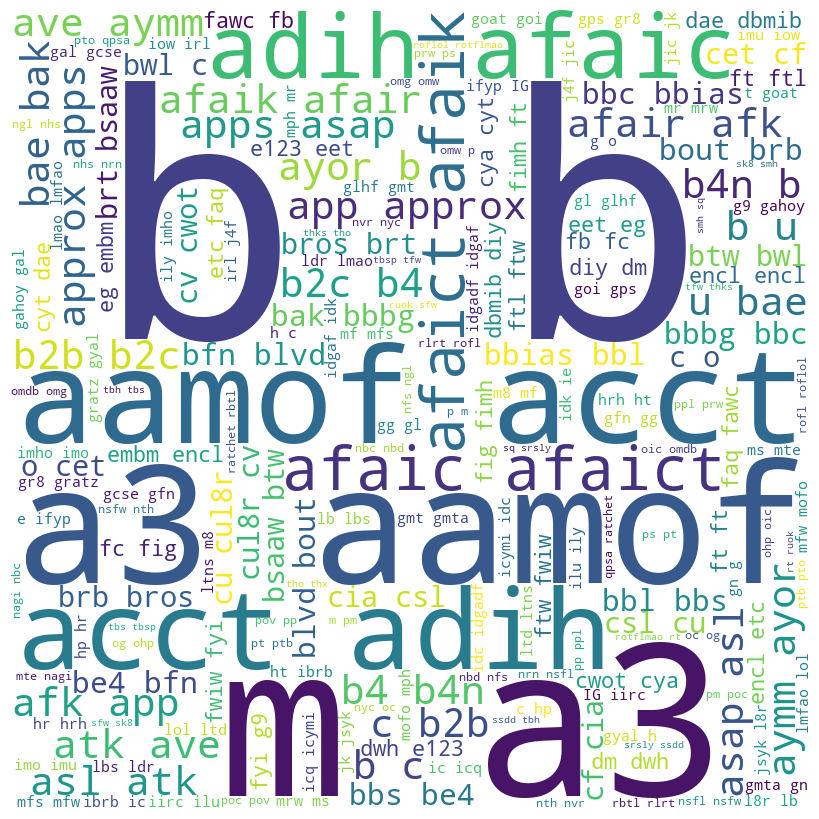

In [116]:
#Generating Word Coud

token = list(abbreviations.keys())
comment_words = ''
stopWords = set(STOPWORDS)


for i in range(len(token)):
    token[i] = token[i].lower()

    comment_words += " ".join(token)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopWords,
                min_font_size = 10).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

In [117]:
# Remove all URLs, replace by URL
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'URL',text)


# Remove HTML beacon
def remove_HTML(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

# Remove non printable characters
def remove_not_ASCII(text):
    text = ''.join([word for word in text if word in string.printable])
    return text

# Change an abbreviation by its true meaning
def word_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

# Replace all abbreviations
def replace_abbrev(text):
    string = ""
    for word in text.split():
        string += word_abbrev(word) + " "
    return string

# Remove @ and mention, replace by USER
def remove_mention(text):
    at=re.compile(r'@\S+')
    return at.sub(r'USER',text)


# Remove numbers, replace it by NUMBER
def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'NUMBER', text)



# Replace some others smileys with SADFACE
def transcription_sad(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[(\\/]')
    return smiley.sub(r'SADFACE', text)


# Replace some smileys with SMILE
def transcription_smile(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[)dDp]')
    #smiley = re.compile(r'#{eyes}#{nose}[)d]+|[)d]+#{nose}#{eyes}/i')
    return smiley.sub(r'SMILE', text)


# Replace <3 with HEART
def transcription_heart(text):
    heart = re.compile(r'<3')
    return heart.sub(r'HEART', text)


# Factorize elongated words, add ELONG
def remove_elongated_words(text):
    rep = re.compile(r'\b(\S*?)([a-z])\2{2,}\b')
    return rep.sub(r'\1\2 ELONG', text)


# Factorize repeated punctuation, add REPEAT
def remove_repeat_punct(text):
    rep = re.compile(r'([!?.]){2,}')
    return rep.sub(r'\1 REPEAT', text)



# Remove all punctuations
def remove_all_punct(text):
    table = str.maketrans('','',string.punctuation)
    return text.translate(table)


# Remove punctuations
def remove_punct(text):
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        text = text.replace(p, f' {p} ')

    text = text.replace('...', ' ... ')
    if '...' not in text:
        text = text.replace('..', ' ... ')
    return text


# Remove all english stopwords
def remove_stopwords(text):
    text = ' '.join([word for word in text.split() if word not in stopwords.words("english")])
    return text

def stemming(text):
    ps = PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

def lemmatization(text):
    lm= WordNetLemmatizer()
    text = ' '.join([lm.lemmatize(word, pos='v') for word in text.split()])
    return text

In [118]:
def clean_text(text):

    # Remove non text
    text = remove_URL(text)
    text = remove_HTML(text)
    text = remove_not_ASCII(text)

    # Lower text, replace abbreviations
    text = replace_abbrev(text)
    text = remove_mention(text)
    text = remove_number(text)

    # Remove  smileys

    text = transcription_sad(text)
    text = transcription_smile(text)
    text = transcription_heart(text)

    # Remove repeated puntuations / words
    text = remove_elongated_words(text)
    text = remove_repeat_punct(text)

    text = remove_all_punct(text)
    text = remove_punct(text)
    text = lemmatization(text)
    text = text.lower()

    return text

In [119]:

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jusbrasil/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [120]:
#cleaning text in data frames
df["textclean"] = df["text"].apply(clean_text)

In [121]:
df[["textclean", "text", "category"]].iloc[90]

textclean    slovakia reach hopman cup final slovakia will ...
text         slovakia reach hopman cup final slovakia will ...
category                                                 sport
Name: 90, dtype: object

<Axes: >

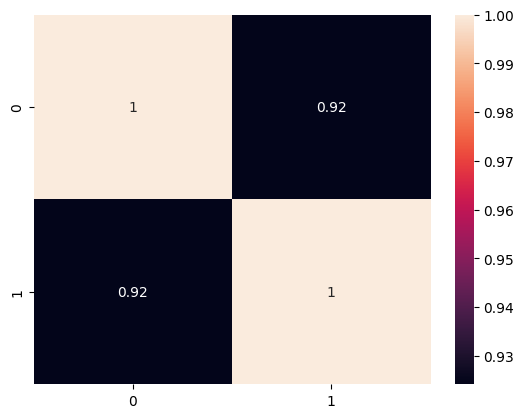

In [122]:
textclean, text = df[["textclean", "text", "category"]].iloc[90]['textclean'], df[["textclean", "text", "category"]].iloc[90]['text']
textclean, text = embed([textclean]), embed([text])
matrix = np.corrcoef(textclean, text)
sns.heatmap(matrix, annot=True)

In [123]:
sentences = df["textclean"].apply(lambda x: x.lower()).tolist()
# generating training data matrix
embed_matrix = []
for sent in sentences:
    embed_matrix.append(np.array(embed([sent])[0]).tolist())

In [124]:
# Transforming catagories label
lb = LabelBinarizer().fit(list(set(df['category'].tolist())))

In [125]:
X, Y = np.array(embed_matrix), lb.transform(df['category'].tolist())

x_train, x_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

In [126]:
from itertools import product

learning_rates = [0.001, 0.0001, 0.00001]
units_values = [64, 128, 256]
epochs_values = [5, 20, 40]

# Creating all possible combinations of hyperparameters
hyperparameter_combinations = list(product(learning_rates, units_values, epochs_values))

input_dim = 512

# Dictionary to store training results for each combination
all_results = {}

# Training the models for each possible combination
for learning_rate, units, epochs in hyperparameter_combinations:
    # Model Architecture
    ann = tf.keras.models.Sequential()
    ann.add(tf.keras.Input(shape=input_dim))
    ann.add(tf.keras.layers.Dense(units=units, activation='relu'))
    ann.add(tf.keras.layers.Dropout(0.5))
    ann.add(tf.keras.layers.Dense(units=5, activation='softmax'))

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    ann.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = ann.fit(x_train, y_train, epochs=epochs, batch_size=10, validation_split=0.20)

    # Get the final training loss and accuracy
    final_train_loss = history.history['loss'][-1]
    final_train_accuracy = history.history['accuracy'][-1]

    # Get the validation loss and accuracy if available
    if 'val_loss' in history.history and 'val_accuracy' in history.history:
        final_val_loss = history.history['val_loss'][-1]
        final_val_accuracy = history.history['val_accuracy'][-1]
    else:
        final_val_loss = None
        final_val_accuracy = None

    # Store relevant information in the dictionary
    model_key = f"LR_{learning_rate}_Units_{units}_Epochs_{epochs}"
    all_results[model_key] = {
        'learning_rate': learning_rate,
        'units': units,
        'epochs': epochs,
        'final_train_loss': final_train_loss,
        'final_train_accuracy': final_train_accuracy,
        'final_val_loss': final_val_loss,
        'final_val_accuracy': final_val_accuracy
    }

Epoch 1/5
125/125 [==============================] - 0s 1ms/step - loss: 1.1378 - accuracy: 0.7928 - val_loss: 0.5570 - val_accuracy: 0.9840
Epoch 2/5
125/125 [==============================] - 0s 606us/step - loss: 0.4472 - accuracy: 0.9357 - val_loss: 0.2175 - val_accuracy: 0.9776
Epoch 3/5
125/125 [==============================] - 0s 618us/step - loss: 0.2557 - accuracy: 0.9398 - val_loss: 0.1307 - val_accuracy: 0.9872
Epoch 4/5
125/125 [==============================] - 0s 607us/step - loss: 0.1829 - accuracy: 0.9631 - val_loss: 0.0972 - val_accuracy: 0.9840
Epoch 5/5
125/125 [==============================] - 0s 600us/step - loss: 0.1479 - accuracy: 0.9622 - val_loss: 0.0814 - val_accuracy: 0.9936


Epoch 1/20
125/125 [==============================] - 0s 1ms/step - loss: 1.1300 - accuracy: 0.7695 - val_loss: 0.5504 - val_accuracy: 0.9679
Epoch 2/20
125/125 [==============================] - 0s 613us/step - loss: 0.4406 - accuracy: 0.9237 - val_loss: 0.2222 - val_accuracy: 0.9679
Epoch 3/20
125/125 [==============================] - 0s 617us/step - loss: 0.2522 - accuracy: 0.9486 - val_loss: 0.1367 - val_accuracy: 0.9840
Epoch 4/20
125/125 [==============================] - 0s 617us/step - loss: 0.1777 - accuracy: 0.9622 - val_loss: 0.1022 - val_accuracy: 0.9776
Epoch 5/20
125/125 [==============================] - 0s 610us/step - loss: 0.1464 - accuracy: 0.9655 - val_loss: 0.0893 - val_accuracy: 0.9936
Epoch 6/20
125/125 [==============================] - 0s 610us/step - loss: 0.1265 - accuracy: 0.9719 - val_loss: 0.0732 - val_accuracy: 0.9872
Epoch 7/20
125/125 [==============================] - 0s 607us/step - loss: 0.1044 - accuracy: 0.9743 - val_loss: 0.0645 - val_accuracy: 0

Epoch 1/40
125/125 [==============================] - 0s 1ms/step - loss: 1.1754 - accuracy: 0.7357 - val_loss: 0.5921 - val_accuracy: 0.9744
Epoch 2/40
125/125 [==============================] - 0s 638us/step - loss: 0.4532 - accuracy: 0.9373 - val_loss: 0.2179 - val_accuracy: 0.9744
Epoch 3/40
125/125 [==============================] - 0s 610us/step - loss: 0.2513 - accuracy: 0.9518 - val_loss: 0.1321 - val_accuracy: 0.9840
Epoch 4/40
125/125 [==============================] - 0s 606us/step - loss: 0.1789 - accuracy: 0.9614 - val_loss: 0.0984 - val_accuracy: 0.9840
Epoch 5/40
125/125 [==============================] - 0s 630us/step - loss: 0.1391 - accuracy: 0.9695 - val_loss: 0.0802 - val_accuracy: 0.9872
Epoch 6/40
125/125 [==============================] - 0s 619us/step - loss: 0.1197 - accuracy: 0.9687 - val_loss: 0.0698 - val_accuracy: 0.9936
Epoch 7/40
125/125 [==============================] - 0s 599us/step - loss: 0.1005 - accuracy: 0.9767 - val_loss: 0.0679 - val_accuracy: 0

Epoch 1/5
125/125 [==============================] - 0s 1ms/step - loss: 0.9908 - accuracy: 0.8273 - val_loss: 0.3518 - val_accuracy: 0.9712
Epoch 2/5
125/125 [==============================] - 0s 669us/step - loss: 0.2824 - accuracy: 0.9550 - val_loss: 0.1410 - val_accuracy: 0.9808
Epoch 3/5
125/125 [==============================] - 0s 681us/step - loss: 0.1573 - accuracy: 0.9647 - val_loss: 0.0942 - val_accuracy: 0.9744
Epoch 4/5
125/125 [==============================] - 0s 659us/step - loss: 0.1095 - accuracy: 0.9727 - val_loss: 0.0736 - val_accuracy: 0.9872
Epoch 5/5
125/125 [==============================] - 0s 681us/step - loss: 0.0881 - accuracy: 0.9815 - val_loss: 0.0680 - val_accuracy: 0.9936


Epoch 1/20
125/125 [==============================] - 0s 1ms/step - loss: 0.9700 - accuracy: 0.8201 - val_loss: 0.3545 - val_accuracy: 0.9712
Epoch 2/20
125/125 [==============================] - 0s 677us/step - loss: 0.2795 - accuracy: 0.9558 - val_loss: 0.1415 - val_accuracy: 0.9808
Epoch 3/20
125/125 [==============================] - 0s 662us/step - loss: 0.1620 - accuracy: 0.9614 - val_loss: 0.0949 - val_accuracy: 0.9904
Epoch 4/20
125/125 [==============================] - 0s 656us/step - loss: 0.1105 - accuracy: 0.9751 - val_loss: 0.0756 - val_accuracy: 0.9872
Epoch 5/20
125/125 [==============================] - 0s 666us/step - loss: 0.0937 - accuracy: 0.9743 - val_loss: 0.0693 - val_accuracy: 0.9872
Epoch 6/20
125/125 [==============================] - 0s 679us/step - loss: 0.0725 - accuracy: 0.9847 - val_loss: 0.0569 - val_accuracy: 0.9904
Epoch 7/20
125/125 [==============================] - 0s 716us/step - loss: 0.0621 - accuracy: 0.9847 - val_loss: 0.0545 - val_accuracy: 0

Epoch 1/40
125/125 [==============================] - 0s 1ms/step - loss: 0.9712 - accuracy: 0.7992 - val_loss: 0.3466 - val_accuracy: 0.9744
Epoch 2/40
125/125 [==============================] - 0s 674us/step - loss: 0.2738 - accuracy: 0.9518 - val_loss: 0.1448 - val_accuracy: 0.9776
Epoch 3/40
125/125 [==============================] - 0s 665us/step - loss: 0.1656 - accuracy: 0.9647 - val_loss: 0.0968 - val_accuracy: 0.9776
Epoch 4/40
125/125 [==============================] - 0s 653us/step - loss: 0.1241 - accuracy: 0.9663 - val_loss: 0.0777 - val_accuracy: 0.9808
Epoch 5/40
125/125 [==============================] - 0s 672us/step - loss: 0.0916 - accuracy: 0.9791 - val_loss: 0.0714 - val_accuracy: 0.9904
Epoch 6/40
125/125 [==============================] - 0s 660us/step - loss: 0.0701 - accuracy: 0.9847 - val_loss: 0.0608 - val_accuracy: 0.9936
Epoch 7/40
125/125 [==============================] - 0s 655us/step - loss: 0.0623 - accuracy: 0.9823 - val_loss: 0.0550 - val_accuracy: 0

Epoch 1/5
125/125 [==============================] - 0s 1ms/step - loss: 0.8045 - accuracy: 0.8506 - val_loss: 0.2183 - val_accuracy: 0.9904
Epoch 2/5
125/125 [==============================] - 0s 762us/step - loss: 0.1823 - accuracy: 0.9574 - val_loss: 0.1018 - val_accuracy: 0.9808
Epoch 3/5
125/125 [==============================] - 0s 754us/step - loss: 0.1075 - accuracy: 0.9759 - val_loss: 0.0727 - val_accuracy: 0.9872
Epoch 4/5
125/125 [==============================] - 0s 768us/step - loss: 0.0758 - accuracy: 0.9847 - val_loss: 0.0587 - val_accuracy: 0.9904
Epoch 5/5
125/125 [==============================] - 0s 757us/step - loss: 0.0543 - accuracy: 0.9888 - val_loss: 0.0564 - val_accuracy: 0.9840


Epoch 1/20
125/125 [==============================] - 0s 1ms/step - loss: 0.7942 - accuracy: 0.8618 - val_loss: 0.2158 - val_accuracy: 0.9808
Epoch 2/20
125/125 [==============================] - 0s 769us/step - loss: 0.1840 - accuracy: 0.9631 - val_loss: 0.1050 - val_accuracy: 0.9808
Epoch 3/20
125/125 [==============================] - 0s 750us/step - loss: 0.1067 - accuracy: 0.9743 - val_loss: 0.0726 - val_accuracy: 0.9872
Epoch 4/20
125/125 [==============================] - 0s 759us/step - loss: 0.0817 - accuracy: 0.9823 - val_loss: 0.0595 - val_accuracy: 0.9904
Epoch 5/20
125/125 [==============================] - 0s 741us/step - loss: 0.0522 - accuracy: 0.9912 - val_loss: 0.0607 - val_accuracy: 0.9904
Epoch 6/20
125/125 [==============================] - 0s 742us/step - loss: 0.0422 - accuracy: 0.9928 - val_loss: 0.0583 - val_accuracy: 0.9808
Epoch 7/20
125/125 [==============================] - 0s 748us/step - loss: 0.0349 - accuracy: 0.9928 - val_loss: 0.0483 - val_accuracy: 0

Epoch 1/40
125/125 [==============================] - 0s 1ms/step - loss: 0.8150 - accuracy: 0.8386 - val_loss: 0.2283 - val_accuracy: 0.9808
Epoch 2/40
125/125 [==============================] - 0s 776us/step - loss: 0.1871 - accuracy: 0.9590 - val_loss: 0.1043 - val_accuracy: 0.9808
Epoch 3/40
125/125 [==============================] - 0s 764us/step - loss: 0.1117 - accuracy: 0.9727 - val_loss: 0.0749 - val_accuracy: 0.9872
Epoch 4/40
125/125 [==============================] - 0s 766us/step - loss: 0.0758 - accuracy: 0.9847 - val_loss: 0.0634 - val_accuracy: 0.9872
Epoch 5/40
125/125 [==============================] - 0s 795us/step - loss: 0.0598 - accuracy: 0.9863 - val_loss: 0.0599 - val_accuracy: 0.9872
Epoch 6/40
125/125 [==============================] - 0s 788us/step - loss: 0.0498 - accuracy: 0.9896 - val_loss: 0.0547 - val_accuracy: 0.9872
Epoch 7/40
125/125 [==============================] - 0s 806us/step - loss: 0.0385 - accuracy: 0.9912 - val_loss: 0.0524 - val_accuracy: 0

Epoch 1/5
125/125 [==============================] - 0s 1ms/step - loss: 1.5834 - accuracy: 0.3189 - val_loss: 1.5437 - val_accuracy: 0.5288
Epoch 2/5
125/125 [==============================] - 1s 7ms/step - loss: 1.4987 - accuracy: 0.5655 - val_loss: 1.4360 - val_accuracy: 0.7788
Epoch 3/5
125/125 [==============================] - 0s 597us/step - loss: 1.3836 - accuracy: 0.7406 - val_loss: 1.2929 - val_accuracy: 0.8974
Epoch 4/5
125/125 [==============================] - 0s 600us/step - loss: 1.2361 - accuracy: 0.8554 - val_loss: 1.1337 - val_accuracy: 0.9263
Epoch 5/5
125/125 [==============================] - 0s 601us/step - loss: 1.0870 - accuracy: 0.8900 - val_loss: 0.9850 - val_accuracy: 0.9487


Epoch 1/20
125/125 [==============================] - 0s 1ms/step - loss: 1.5844 - accuracy: 0.3341 - val_loss: 1.5406 - val_accuracy: 0.7051
Epoch 2/20
125/125 [==============================] - 0s 626us/step - loss: 1.4935 - accuracy: 0.6691 - val_loss: 1.4334 - val_accuracy: 0.8846
Epoch 3/20
125/125 [==============================] - 0s 622us/step - loss: 1.3779 - accuracy: 0.7880 - val_loss: 1.2948 - val_accuracy: 0.9295
Epoch 4/20
125/125 [==============================] - 0s 610us/step - loss: 1.2442 - accuracy: 0.8474 - val_loss: 1.1489 - val_accuracy: 0.9519
Epoch 5/20
125/125 [==============================] - 0s 614us/step - loss: 1.1087 - accuracy: 0.8747 - val_loss: 1.0065 - val_accuracy: 0.9487
Epoch 6/20
125/125 [==============================] - 0s 635us/step - loss: 0.9796 - accuracy: 0.9149 - val_loss: 0.8787 - val_accuracy: 0.9551
Epoch 7/20
125/125 [==============================] - 0s 648us/step - loss: 0.8760 - accuracy: 0.9116 - val_loss: 0.7678 - val_accuracy: 0

Epoch 1/40
125/125 [==============================] - 0s 1ms/step - loss: 1.5877 - accuracy: 0.3141 - val_loss: 1.5407 - val_accuracy: 0.6667
Epoch 2/40
125/125 [==============================] - 0s 623us/step - loss: 1.4982 - accuracy: 0.6129 - val_loss: 1.4364 - val_accuracy: 0.8494
Epoch 3/40
125/125 [==============================] - 0s 727us/step - loss: 1.3820 - accuracy: 0.7711 - val_loss: 1.3041 - val_accuracy: 0.9135
Epoch 4/40
125/125 [==============================] - 0s 691us/step - loss: 1.2562 - accuracy: 0.8321 - val_loss: 1.1650 - val_accuracy: 0.9359
Epoch 5/40
125/125 [==============================] - 0s 662us/step - loss: 1.1339 - accuracy: 0.8683 - val_loss: 1.0308 - val_accuracy: 0.9327
Epoch 6/40
125/125 [==============================] - 0s 632us/step - loss: 1.0264 - accuracy: 0.8747 - val_loss: 0.9084 - val_accuracy: 0.9519
Epoch 7/40
125/125 [==============================] - 0s 628us/step - loss: 0.9055 - accuracy: 0.9068 - val_loss: 0.7923 - val_accuracy: 0

Epoch 1/5
125/125 [==============================] - 0s 1ms/step - loss: 1.5694 - accuracy: 0.3855 - val_loss: 1.5047 - val_accuracy: 0.7564
Epoch 2/5
125/125 [==============================] - 0s 675us/step - loss: 1.4309 - accuracy: 0.7494 - val_loss: 1.3423 - val_accuracy: 0.8814
Epoch 3/5
125/125 [==============================] - 0s 690us/step - loss: 1.2646 - accuracy: 0.8586 - val_loss: 1.1561 - val_accuracy: 0.9295
Epoch 4/5
125/125 [==============================] - 0s 671us/step - loss: 1.0933 - accuracy: 0.8763 - val_loss: 0.9770 - val_accuracy: 0.9487
Epoch 5/5
125/125 [==============================] - 0s 673us/step - loss: 0.9267 - accuracy: 0.9181 - val_loss: 0.8142 - val_accuracy: 0.9519


Epoch 1/20
125/125 [==============================] - 0s 1ms/step - loss: 1.5479 - accuracy: 0.4345 - val_loss: 1.4736 - val_accuracy: 0.7917
Epoch 2/20
125/125 [==============================] - 0s 702us/step - loss: 1.4095 - accuracy: 0.7502 - val_loss: 1.3098 - val_accuracy: 0.8942
Epoch 3/20
125/125 [==============================] - 0s 729us/step - loss: 1.2360 - accuracy: 0.8610 - val_loss: 1.1193 - val_accuracy: 0.9391
Epoch 4/20
125/125 [==============================] - 0s 678us/step - loss: 1.0518 - accuracy: 0.9141 - val_loss: 0.9350 - val_accuracy: 0.9583
Epoch 5/20
125/125 [==============================] - 0s 677us/step - loss: 0.8986 - accuracy: 0.9293 - val_loss: 0.7724 - val_accuracy: 0.9615
Epoch 6/20
125/125 [==============================] - 0s 684us/step - loss: 0.7524 - accuracy: 0.9390 - val_loss: 0.6375 - val_accuracy: 0.9679
Epoch 7/20
125/125 [==============================] - 0s 683us/step - loss: 0.6362 - accuracy: 0.9382 - val_loss: 0.5315 - val_accuracy: 0

Epoch 1/40
125/125 [==============================] - 0s 1ms/step - loss: 1.5580 - accuracy: 0.4265 - val_loss: 1.4827 - val_accuracy: 0.7821
Epoch 2/40
125/125 [==============================] - 0s 678us/step - loss: 1.4190 - accuracy: 0.7446 - val_loss: 1.3189 - val_accuracy: 0.9135
Epoch 3/40
125/125 [==============================] - 0s 690us/step - loss: 1.2469 - accuracy: 0.8474 - val_loss: 1.1275 - val_accuracy: 0.9487
Epoch 4/40
125/125 [==============================] - 0s 678us/step - loss: 1.0711 - accuracy: 0.8996 - val_loss: 0.9416 - val_accuracy: 0.9487
Epoch 5/40
125/125 [==============================] - 0s 672us/step - loss: 0.8999 - accuracy: 0.9173 - val_loss: 0.7773 - val_accuracy: 0.9583
Epoch 6/40
125/125 [==============================] - 0s 680us/step - loss: 0.7578 - accuracy: 0.9325 - val_loss: 0.6411 - val_accuracy: 0.9647
Epoch 7/40
125/125 [==============================] - 0s 694us/step - loss: 0.6443 - accuracy: 0.9317 - val_loss: 0.5342 - val_accuracy: 0

Epoch 1/5
125/125 [==============================] - 0s 1ms/step - loss: 1.5399 - accuracy: 0.4819 - val_loss: 1.4391 - val_accuracy: 0.8526
Epoch 2/5
125/125 [==============================] - 0s 763us/step - loss: 1.3298 - accuracy: 0.8627 - val_loss: 1.1946 - val_accuracy: 0.9327
Epoch 3/5
125/125 [==============================] - 0s 767us/step - loss: 1.0919 - accuracy: 0.9068 - val_loss: 0.9389 - val_accuracy: 0.9551
Epoch 4/5
125/125 [==============================] - 0s 765us/step - loss: 0.8595 - accuracy: 0.9333 - val_loss: 0.7199 - val_accuracy: 0.9551
Epoch 5/5
125/125 [==============================] - 0s 758us/step - loss: 0.6725 - accuracy: 0.9438 - val_loss: 0.5535 - val_accuracy: 0.9647


Epoch 1/20
125/125 [==============================] - 0s 1ms/step - loss: 1.5294 - accuracy: 0.5743 - val_loss: 1.4263 - val_accuracy: 0.8365
Epoch 2/20
125/125 [==============================] - 0s 781us/step - loss: 1.3280 - accuracy: 0.8329 - val_loss: 1.1823 - val_accuracy: 0.8974
Epoch 3/20
125/125 [==============================] - 0s 788us/step - loss: 1.0863 - accuracy: 0.8932 - val_loss: 0.9234 - val_accuracy: 0.9423
Epoch 4/20
125/125 [==============================] - 0s 763us/step - loss: 0.8510 - accuracy: 0.9317 - val_loss: 0.7058 - val_accuracy: 0.9519
Epoch 5/20
125/125 [==============================] - 0s 769us/step - loss: 0.6630 - accuracy: 0.9430 - val_loss: 0.5413 - val_accuracy: 0.9519
Epoch 6/20
125/125 [==============================] - 0s 737us/step - loss: 0.5246 - accuracy: 0.9470 - val_loss: 0.4263 - val_accuracy: 0.9712
Epoch 7/20
125/125 [==============================] - 0s 744us/step - loss: 0.4248 - accuracy: 0.9550 - val_loss: 0.3457 - val_accuracy: 0

Epoch 1/40
125/125 [==============================] - 0s 1ms/step - loss: 1.5276 - accuracy: 0.5285 - val_loss: 1.4224 - val_accuracy: 0.8333
Epoch 2/40
125/125 [==============================] - 0s 749us/step - loss: 1.3217 - accuracy: 0.8458 - val_loss: 1.1761 - val_accuracy: 0.9199
Epoch 3/40
125/125 [==============================] - 0s 788us/step - loss: 1.0685 - accuracy: 0.9165 - val_loss: 0.9151 - val_accuracy: 0.9391
Epoch 4/40
125/125 [==============================] - 0s 770us/step - loss: 0.8371 - accuracy: 0.9341 - val_loss: 0.7009 - val_accuracy: 0.9519
Epoch 5/40
125/125 [==============================] - 0s 745us/step - loss: 0.6512 - accuracy: 0.9486 - val_loss: 0.5389 - val_accuracy: 0.9615
Epoch 6/40
125/125 [==============================] - 0s 747us/step - loss: 0.5202 - accuracy: 0.9454 - val_loss: 0.4253 - val_accuracy: 0.9744
Epoch 7/40
125/125 [==============================] - 0s 779us/step - loss: 0.4276 - accuracy: 0.9574 - val_loss: 0.3455 - val_accuracy: 0

Epoch 1/5
125/125 [==============================] - 0s 1ms/step - loss: 1.6115 - accuracy: 0.1799 - val_loss: 1.6069 - val_accuracy: 0.2404
Epoch 2/5
125/125 [==============================] - 0s 642us/step - loss: 1.6028 - accuracy: 0.2538 - val_loss: 1.5981 - val_accuracy: 0.3045
Epoch 3/5
125/125 [==============================] - 0s 634us/step - loss: 1.5956 - accuracy: 0.2643 - val_loss: 1.5893 - val_accuracy: 0.3558
Epoch 4/5
125/125 [==============================] - 0s 638us/step - loss: 1.5870 - accuracy: 0.3068 - val_loss: 1.5803 - val_accuracy: 0.4263
Epoch 5/5
125/125 [==============================] - 0s 664us/step - loss: 1.5800 - accuracy: 0.3406 - val_loss: 1.5712 - val_accuracy: 0.4647


Epoch 1/20
125/125 [==============================] - 0s 1ms/step - loss: 1.6078 - accuracy: 0.2297 - val_loss: 1.6026 - val_accuracy: 0.2564
Epoch 2/20
125/125 [==============================] - 0s 639us/step - loss: 1.6000 - accuracy: 0.2466 - val_loss: 1.5949 - val_accuracy: 0.2692
Epoch 3/20
125/125 [==============================] - 0s 647us/step - loss: 1.5940 - accuracy: 0.2506 - val_loss: 1.5873 - val_accuracy: 0.2788
Epoch 4/20
125/125 [==============================] - 0s 659us/step - loss: 1.5841 - accuracy: 0.3036 - val_loss: 1.5797 - val_accuracy: 0.2917
Epoch 5/20
125/125 [==============================] - 0s 641us/step - loss: 1.5789 - accuracy: 0.3044 - val_loss: 1.5719 - val_accuracy: 0.3045
Epoch 6/20
125/125 [==============================] - 0s 629us/step - loss: 1.5723 - accuracy: 0.3229 - val_loss: 1.5640 - val_accuracy: 0.3397
Epoch 7/20
125/125 [==============================] - 0s 631us/step - loss: 1.5612 - accuracy: 0.3855 - val_loss: 1.5558 - val_accuracy: 0

Epoch 1/40
125/125 [==============================] - 0s 1ms/step - loss: 1.5944 - accuracy: 0.2924 - val_loss: 1.5891 - val_accuracy: 0.3622
Epoch 2/40
125/125 [==============================] - 0s 634us/step - loss: 1.5871 - accuracy: 0.2988 - val_loss: 1.5806 - val_accuracy: 0.4038
Epoch 3/40
125/125 [==============================] - 0s 624us/step - loss: 1.5809 - accuracy: 0.3245 - val_loss: 1.5722 - val_accuracy: 0.4551
Epoch 4/40
125/125 [==============================] - 0s 626us/step - loss: 1.5752 - accuracy: 0.3590 - val_loss: 1.5638 - val_accuracy: 0.5000
Epoch 5/40
125/125 [==============================] - 0s 624us/step - loss: 1.5648 - accuracy: 0.3767 - val_loss: 1.5552 - val_accuracy: 0.5224
Epoch 6/40
125/125 [==============================] - 0s 619us/step - loss: 1.5603 - accuracy: 0.3896 - val_loss: 1.5464 - val_accuracy: 0.5481
Epoch 7/40
125/125 [==============================] - 0s 617us/step - loss: 1.5472 - accuracy: 0.4297 - val_loss: 1.5375 - val_accuracy: 0

Epoch 1/5
125/125 [==============================] - 0s 1ms/step - loss: 1.6081 - accuracy: 0.1920 - val_loss: 1.6059 - val_accuracy: 0.1795
Epoch 2/5
125/125 [==============================] - 0s 684us/step - loss: 1.6013 - accuracy: 0.2225 - val_loss: 1.5935 - val_accuracy: 0.2244
Epoch 3/5
125/125 [==============================] - 0s 685us/step - loss: 1.5872 - accuracy: 0.2835 - val_loss: 1.5810 - val_accuracy: 0.2949
Epoch 4/5
125/125 [==============================] - 0s 673us/step - loss: 1.5749 - accuracy: 0.3382 - val_loss: 1.5686 - val_accuracy: 0.3814
Epoch 5/5
125/125 [==============================] - 0s 674us/step - loss: 1.5655 - accuracy: 0.3719 - val_loss: 1.5559 - val_accuracy: 0.5064


Epoch 1/20
125/125 [==============================] - 0s 1ms/step - loss: 1.5978 - accuracy: 0.2602 - val_loss: 1.5890 - val_accuracy: 0.4295
Epoch 2/20
125/125 [==============================] - 0s 676us/step - loss: 1.5822 - accuracy: 0.3502 - val_loss: 1.5764 - val_accuracy: 0.5064
Epoch 3/20
125/125 [==============================] - 0s 666us/step - loss: 1.5717 - accuracy: 0.3759 - val_loss: 1.5636 - val_accuracy: 0.5256
Epoch 4/20
125/125 [==============================] - 0s 671us/step - loss: 1.5602 - accuracy: 0.4386 - val_loss: 1.5504 - val_accuracy: 0.5641
Epoch 5/20
125/125 [==============================] - 0s 677us/step - loss: 1.5469 - accuracy: 0.4908 - val_loss: 1.5367 - val_accuracy: 0.6218
Epoch 6/20
125/125 [==============================] - 0s 689us/step - loss: 1.5309 - accuracy: 0.5486 - val_loss: 1.5225 - val_accuracy: 0.6346
Epoch 7/20
125/125 [==============================] - 0s 665us/step - loss: 1.5205 - accuracy: 0.5454 - val_loss: 1.5076 - val_accuracy: 0

Epoch 1/40
125/125 [==============================] - 0s 1ms/step - loss: 1.6007 - accuracy: 0.2458 - val_loss: 1.5899 - val_accuracy: 0.3750
Epoch 2/40
125/125 [==============================] - 0s 696us/step - loss: 1.5872 - accuracy: 0.3068 - val_loss: 1.5779 - val_accuracy: 0.4583
Epoch 3/40
125/125 [==============================] - 0s 687us/step - loss: 1.5777 - accuracy: 0.3542 - val_loss: 1.5655 - val_accuracy: 0.5641
Epoch 4/40
125/125 [==============================] - 0s 679us/step - loss: 1.5647 - accuracy: 0.4386 - val_loss: 1.5533 - val_accuracy: 0.6699
Epoch 5/40
125/125 [==============================] - 0s 677us/step - loss: 1.5548 - accuracy: 0.4570 - val_loss: 1.5406 - val_accuracy: 0.7404
Epoch 6/40
125/125 [==============================] - 0s 708us/step - loss: 1.5431 - accuracy: 0.5430 - val_loss: 1.5276 - val_accuracy: 0.7788
Epoch 7/40
125/125 [==============================] - 0s 681us/step - loss: 1.5270 - accuracy: 0.6040 - val_loss: 1.5140 - val_accuracy: 0

Epoch 1/5
125/125 [==============================] - 0s 1ms/step - loss: 1.6036 - accuracy: 0.2305 - val_loss: 1.5935 - val_accuracy: 0.3462
Epoch 2/5
125/125 [==============================] - 0s 759us/step - loss: 1.5875 - accuracy: 0.2972 - val_loss: 1.5761 - val_accuracy: 0.4231
Epoch 3/5
125/125 [==============================] - 0s 759us/step - loss: 1.5684 - accuracy: 0.3936 - val_loss: 1.5587 - val_accuracy: 0.5032
Epoch 4/5
125/125 [==============================] - 0s 784us/step - loss: 1.5536 - accuracy: 0.4916 - val_loss: 1.5412 - val_accuracy: 0.5897
Epoch 5/5
125/125 [==============================] - 0s 755us/step - loss: 1.5370 - accuracy: 0.5502 - val_loss: 1.5231 - val_accuracy: 0.7019


Epoch 1/20
125/125 [==============================] - 0s 1ms/step - loss: 1.6070 - accuracy: 0.1976 - val_loss: 1.5966 - val_accuracy: 0.3013
Epoch 2/20
125/125 [==============================] - 0s 981us/step - loss: 1.5917 - accuracy: 0.2884 - val_loss: 1.5795 - val_accuracy: 0.4583
Epoch 3/20
125/125 [==============================] - 0s 755us/step - loss: 1.5746 - accuracy: 0.3984 - val_loss: 1.5623 - val_accuracy: 0.5769
Epoch 4/20
125/125 [==============================] - 0s 749us/step - loss: 1.5586 - accuracy: 0.4659 - val_loss: 1.5451 - val_accuracy: 0.6506
Epoch 5/20
125/125 [==============================] - 0s 757us/step - loss: 1.5389 - accuracy: 0.5566 - val_loss: 1.5272 - val_accuracy: 0.6987
Epoch 6/20
125/125 [==============================] - 0s 755us/step - loss: 1.5255 - accuracy: 0.6080 - val_loss: 1.5086 - val_accuracy: 0.7244
Epoch 7/20
125/125 [==============================] - 0s 764us/step - loss: 1.5043 - accuracy: 0.6667 - val_loss: 1.4893 - val_accuracy: 0

Epoch 1/40
125/125 [==============================] - 0s 1ms/step - loss: 1.6003 - accuracy: 0.2361 - val_loss: 1.5916 - val_accuracy: 0.2917
Epoch 2/40
125/125 [==============================] - 0s 783us/step - loss: 1.5824 - accuracy: 0.3269 - val_loss: 1.5740 - val_accuracy: 0.4359
Epoch 3/40
125/125 [==============================] - 0s 765us/step - loss: 1.5650 - accuracy: 0.4185 - val_loss: 1.5563 - val_accuracy: 0.5673
Epoch 4/40
125/125 [==============================] - 0s 783us/step - loss: 1.5498 - accuracy: 0.4980 - val_loss: 1.5384 - val_accuracy: 0.6731
Epoch 5/40
125/125 [==============================] - 0s 763us/step - loss: 1.5303 - accuracy: 0.5751 - val_loss: 1.5197 - val_accuracy: 0.7500
Epoch 6/40
125/125 [==============================] - 0s 759us/step - loss: 1.5141 - accuracy: 0.6281 - val_loss: 1.5004 - val_accuracy: 0.7949
Epoch 7/40
125/125 [==============================] - 0s 765us/step - loss: 1.4943 - accuracy: 0.6699 - val_loss: 1.4804 - val_accuracy: 0

In [127]:
# Showing all the models parameters for analysis.

for k, va in all_results.items():
  print(f'Architecture {k} parameters: ')
  for k, v in va.items():
    print(f'{k}: {v:.6f}')
  print('-----------')

Architecture LR_0.001_Units_64_Epochs_5 parameters: 
learning_rate: 0.001000
units: 64.000000
epochs: 5.000000
final_train_loss: 0.147918
final_train_accuracy: 0.962249
final_val_loss: 0.081368
final_val_accuracy: 0.993590
-----------
Architecture LR_0.001_Units_64_Epochs_20 parameters: 
learning_rate: 0.001000
units: 64.000000
epochs: 20.000000
final_train_loss: 0.028693
final_train_accuracy: 0.995181
final_val_loss: 0.036817
final_val_accuracy: 0.990385
-----------
Architecture LR_0.001_Units_64_Epochs_40 parameters: 
learning_rate: 0.001000
units: 64.000000
epochs: 40.000000
final_train_loss: 0.006162
final_train_accuracy: 0.999197
final_val_loss: 0.041128
final_val_accuracy: 0.983974
-----------
Architecture LR_0.001_Units_128_Epochs_5 parameters: 
learning_rate: 0.001000
units: 128.000000
epochs: 5.000000
final_train_loss: 0.088065
final_train_accuracy: 0.981526
final_val_loss: 0.068045
final_val_accuracy: 0.993590
-----------
Architecture LR_0.001_Units_128_Epochs_20 parameters: 

In [128]:
# Best model architecture:

# Architecture LR_0.0001_Units_256_Epochs_40 parameters:
# learning_rate: 0.000100
# units: 256.000000
# epochs: 40.000000
# final_train_loss: 0.062563
# final_train_accuracy: 0.989667
# final_val_loss: 0.075204
# final_val_accuracy: 0.986239

def build_model(seed=None):
  tf.random.set_seed(seed)

  best_ann = tf.keras.models.Sequential()
  best_ann.add(tf.keras.Input(shape=512))
  best_ann.add(tf.keras.layers.Dense(units=256, activation='relu'))
  best_ann.add(tf.keras.layers.Dropout(0.5))
  best_ann.add(tf.keras.layers.Dense(units=5, activation='softmax'))
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
  best_ann.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics ='categorical_accuracy')
  model = best_ann
  return model

In [129]:
!pip install scikeras


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [130]:
from scikeras.wrappers import KerasClassifier

In [131]:
# Testing 5 different seeds (5 different initial values, hence, 5 fits)

seeds = [1, 2, 3, 4, 5]  # For the sake of reproducibility
models = {}

for seed in seeds:
  model = build_model(seed)
  Kmodel = KerasClassifier(build_fn=build_model, batch_size=10, verbose=1)

  model_history = model.fit(x_train, y_train, epochs=40, batch_size=10, validation_split=0.20)

  # Implementing the 10-fold cross validation
  scores = cross_val_score(Kmodel, X, Y, cv=10, scoring='accuracy')


  # Get the final training loss and accuracy
  final_train_loss = model_history.history['loss'][-1]
  final_train_accuracy = model_history.history['categorical_accuracy'][-1]

  # Get the validation loss and accuracy if available
  # if 'val_loss' in history.history and 'val_accuracy' in history.history:
  final_val_loss = model_history.history['val_loss'][-1]
  final_val_accuracy = model_history.history['val_categorical_accuracy'][-1]
  # else:
  #     final_val_loss = None
  #     final_val_accuracy = None

  model_key = f"best_architecture_seed_{seed}"
  models[model_key] = {
    'final_train_loss': f'{final_train_loss:.4f}',
    'final_train_accuracy': f'{final_train_accuracy:.4f}',
    'final_val_loss': f'{final_val_loss:.4f}',
    'final_val_accuracy': f'{final_val_accuracy:.4f}',
    '10_fold_average': f'{scores.mean():.4f}',
    '10_fold_standard deviation': f'{scores.std():.4f}',
    'seed': seed
    }

  # Cleaning the variable
  model_history = ''
  Kmodel = ''

# Best model with seed = 1:
# model = build_model(1)

# best_model = build_model()

# Kmodel = KerasClassifier(build_fn=build_model, verbose=1)

Epoch 1/40
125/125 [==============================] - 0s 1ms/step - loss: 1.5274 - categorical_accuracy: 0.5743 - val_loss: 1.4204 - val_categorical_accuracy: 0.8718
Epoch 2/40
125/125 [==============================] - 0s 775us/step - loss: 1.3176 - categorical_accuracy: 0.8418 - val_loss: 1.1694 - val_categorical_accuracy: 0.9038
Epoch 3/40
125/125 [==============================] - 0s 787us/step - loss: 1.0709 - categorical_accuracy: 0.9060 - val_loss: 0.9093 - val_categorical_accuracy: 0.9391
Epoch 4/40
125/125 [==============================] - 0s 760us/step - loss: 0.8361 - categorical_accuracy: 0.9341 - val_loss: 0.6868 - val_categorical_accuracy: 0.9455
Epoch 5/40
125/125 [==============================] - 0s 771us/step - loss: 0.6483 - categorical_accuracy: 0.9494 - val_loss: 0.5260 - val_categorical_accuracy: 0.9551
Epoch 6/40
125/125 [==============================] - 0s 754us/step - loss: 0.5181 - categorical_accuracy: 0.9438 - val_loss: 0.4144 - val_categorical_accuracy: 0

23/23 [==============================] - 0s 402us/step


23/23 [==============================] - 0s 395us/step


23/23 [==============================] - 0s 395us/step


23/23 [==============================] - 0s 394us/step


23/23 [==============================] - 0s 414us/step


23/23 [==============================] - 0s 390us/step


23/23 [==============================] - 0s 396us/step


23/23 [==============================] - 0s 403us/step


23/23 [==============================] - 0s 445us/step


23/23 [==============================] - 0s 397us/step


Epoch 1/40
125/125 [==============================] - 0s 1ms/step - loss: 1.5373 - categorical_accuracy: 0.5060 - val_loss: 1.4325 - val_categorical_accuracy: 0.8397
Epoch 2/40
125/125 [==============================] - 0s 746us/step - loss: 1.3316 - categorical_accuracy: 0.8241 - val_loss: 1.1794 - val_categorical_accuracy: 0.9006
Epoch 3/40
125/125 [==============================] - 0s 766us/step - loss: 1.0781 - categorical_accuracy: 0.8876 - val_loss: 0.9178 - val_categorical_accuracy: 0.9487
Epoch 4/40
125/125 [==============================] - 0s 746us/step - loss: 0.8420 - categorical_accuracy: 0.9309 - val_loss: 0.7013 - val_categorical_accuracy: 0.9615
Epoch 5/40
125/125 [==============================] - 0s 745us/step - loss: 0.6566 - categorical_accuracy: 0.9430 - val_loss: 0.5415 - val_categorical_accuracy: 0.9647
Epoch 6/40
125/125 [==============================] - 0s 739us/step - loss: 0.5266 - categorical_accuracy: 0.9414 - val_loss: 0.4276 - val_categorical_accuracy: 0

23/23 [==============================] - 0s 384us/step


23/23 [==============================] - 0s 398us/step


23/23 [==============================] - 0s 394us/step


23/23 [==============================] - 0s 405us/step


23/23 [==============================] - 0s 406us/step


23/23 [==============================] - 0s 402us/step


23/23 [==============================] - 0s 398us/step


23/23 [==============================] - 0s 393us/step


23/23 [==============================] - 0s 389us/step


23/23 [==============================] - 0s 392us/step


Epoch 1/40
125/125 [==============================] - 0s 1ms/step - loss: 1.5380 - categorical_accuracy: 0.4932 - val_loss: 1.4288 - val_categorical_accuracy: 0.8077
Epoch 2/40
125/125 [==============================] - 0s 786us/step - loss: 1.3402 - categorical_accuracy: 0.8032 - val_loss: 1.1940 - val_categorical_accuracy: 0.9167
Epoch 3/40
125/125 [==============================] - 0s 739us/step - loss: 1.1039 - categorical_accuracy: 0.8892 - val_loss: 0.9424 - val_categorical_accuracy: 0.9551
Epoch 4/40
125/125 [==============================] - 0s 871us/step - loss: 0.8643 - categorical_accuracy: 0.9245 - val_loss: 0.7201 - val_categorical_accuracy: 0.9519
Epoch 5/40
125/125 [==============================] - 0s 753us/step - loss: 0.6714 - categorical_accuracy: 0.9446 - val_loss: 0.5506 - val_categorical_accuracy: 0.9679
Epoch 6/40
125/125 [==============================] - 0s 758us/step - loss: 0.5396 - categorical_accuracy: 0.9526 - val_loss: 0.4318 - val_categorical_accuracy: 0

23/23 [==============================] - 0s 420us/step


23/23 [==============================] - 0s 404us/step


23/23 [==============================] - 0s 388us/step


23/23 [==============================] - 0s 396us/step


23/23 [==============================] - 0s 388us/step


23/23 [==============================] - 0s 393us/step


23/23 [==============================] - 0s 398us/step


23/23 [==============================] - 0s 409us/step


23/23 [==============================] - 0s 397us/step


23/23 [==============================] - 0s 395us/step


Epoch 1/40
125/125 [==============================] - 0s 1ms/step - loss: 1.5279 - categorical_accuracy: 0.5703 - val_loss: 1.4273 - val_categorical_accuracy: 0.9038
Epoch 2/40
125/125 [==============================] - 0s 766us/step - loss: 1.3386 - categorical_accuracy: 0.8538 - val_loss: 1.1988 - val_categorical_accuracy: 0.9423
Epoch 3/40
125/125 [==============================] - 0s 747us/step - loss: 1.1033 - categorical_accuracy: 0.9108 - val_loss: 0.9479 - val_categorical_accuracy: 0.9583
Epoch 4/40
125/125 [==============================] - 0s 757us/step - loss: 0.8764 - categorical_accuracy: 0.9309 - val_loss: 0.7263 - val_categorical_accuracy: 0.9583
Epoch 5/40
125/125 [==============================] - 0s 782us/step - loss: 0.6863 - categorical_accuracy: 0.9382 - val_loss: 0.5593 - val_categorical_accuracy: 0.9679
Epoch 6/40
125/125 [==============================] - 0s 818us/step - loss: 0.5409 - categorical_accuracy: 0.9566 - val_loss: 0.4386 - val_categorical_accuracy: 0

23/23 [==============================] - 0s 372us/step


23/23 [==============================] - 0s 392us/step


23/23 [==============================] - 0s 403us/step


23/23 [==============================] - 0s 399us/step


23/23 [==============================] - 0s 401us/step


23/23 [==============================] - 0s 388us/step


23/23 [==============================] - 0s 393us/step


23/23 [==============================] - 0s 397us/step


23/23 [==============================] - 0s 404us/step


23/23 [==============================] - 0s 406us/step


Epoch 1/40
125/125 [==============================] - 0s 1ms/step - loss: 1.5329 - categorical_accuracy: 0.5534 - val_loss: 1.4330 - val_categorical_accuracy: 0.8782
Epoch 2/40
125/125 [==============================] - 0s 745us/step - loss: 1.3371 - categorical_accuracy: 0.8562 - val_loss: 1.1977 - val_categorical_accuracy: 0.9231
Epoch 3/40
125/125 [==============================] - 0s 748us/step - loss: 1.0956 - categorical_accuracy: 0.9052 - val_loss: 0.9398 - val_categorical_accuracy: 0.9487
Epoch 4/40
125/125 [==============================] - 0s 745us/step - loss: 0.8589 - categorical_accuracy: 0.9373 - val_loss: 0.7179 - val_categorical_accuracy: 0.9551
Epoch 5/40
125/125 [==============================] - 0s 752us/step - loss: 0.6738 - categorical_accuracy: 0.9470 - val_loss: 0.5516 - val_categorical_accuracy: 0.9551
Epoch 6/40
125/125 [==============================] - 0s 735us/step - loss: 0.5329 - categorical_accuracy: 0.9510 - val_loss: 0.4343 - val_categorical_accuracy: 0

23/23 [==============================] - 0s 411us/step


23/23 [==============================] - 0s 390us/step


23/23 [==============================] - 0s 394us/step


23/23 [==============================] - 0s 399us/step


23/23 [==============================] - 0s 392us/step


23/23 [==============================] - 0s 386us/step


23/23 [==============================] - 0s 388us/step


23/23 [==============================] - 0s 419us/step


23/23 [==============================] - 0s 398us/step


23/23 [==============================] - 0s 401us/step


In [132]:
# Checking the models
models

{'best_architecture_seed_1': {'final_train_loss': '0.0495',
  'final_train_accuracy': '0.9904',
  'final_val_loss': '0.0566',
  'final_val_accuracy': '0.9904',
  '10_fold_average': '0.8751',
  '10_fold_standard deviation': '0.0358',
  'seed': 1},
 'best_architecture_seed_2': {'final_train_loss': '0.0492',
  'final_train_accuracy': '0.9888',
  'final_val_loss': '0.0561',
  'final_val_accuracy': '0.9904',
  '10_fold_average': '0.8890',
  '10_fold_standard deviation': '0.0419',
  'seed': 2},
 'best_architecture_seed_3': {'final_train_loss': '0.0512',
  'final_train_accuracy': '0.9880',
  'final_val_loss': '0.0564',
  'final_val_accuracy': '0.9904',
  '10_fold_average': '0.8885',
  '10_fold_standard deviation': '0.0306',
  'seed': 3},
 'best_architecture_seed_4': {'final_train_loss': '0.0500',
  'final_train_accuracy': '0.9871',
  'final_val_loss': '0.0570',
  'final_val_accuracy': '0.9904',
  '10_fold_average': '0.8872',
  '10_fold_standard deviation': '0.0430',
  'seed': 4},
 'best_archi

In [133]:
# After several tests, we ended up with the best model Architecture LR_0.0001_Units_256_Epochs_40 with seed 3.

model = build_model(3)

model_history = model.fit(x_train, y_train, epochs=40, batch_size=10, validation_split=0.20)

Epoch 1/40
125/125 [==============================] - 0s 1ms/step - loss: 1.5341 - categorical_accuracy: 0.5052 - val_loss: 1.4265 - val_categorical_accuracy: 0.8782
Epoch 2/40
125/125 [==============================] - 0s 758us/step - loss: 1.3322 - categorical_accuracy: 0.8329 - val_loss: 1.1891 - val_categorical_accuracy: 0.9295
Epoch 3/40
125/125 [==============================] - 0s 771us/step - loss: 1.0992 - categorical_accuracy: 0.8996 - val_loss: 0.9407 - val_categorical_accuracy: 0.9487
Epoch 4/40
125/125 [==============================] - 0s 754us/step - loss: 0.8660 - categorical_accuracy: 0.9301 - val_loss: 0.7277 - val_categorical_accuracy: 0.9583
Epoch 5/40
125/125 [==============================] - 0s 769us/step - loss: 0.6799 - categorical_accuracy: 0.9454 - val_loss: 0.5627 - val_categorical_accuracy: 0.9647
Epoch 6/40
125/125 [==============================] - 0s 749us/step - loss: 0.5479 - categorical_accuracy: 0.9526 - val_loss: 0.4435 - val_categorical_accuracy: 0

In [134]:
# Summary
model.summary()

Model: "sequential_248"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_496 (Dense)           (None, 256)               131328    
                                                                 
 dropout_248 (Dropout)       (None, 256)               0         
                                                                 
 dense_497 (Dense)           (None, 5)                 1285      
                                                                 
Total params: 132613 (518.02 KB)
Trainable params: 132613 (518.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [135]:
!pip install visualkeras pydot graphviz
import visualkeras


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


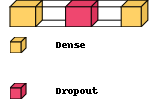

In [136]:
visualkeras.layered_view(ann,legend=True, draw_volume=True, spacing=30)

In [137]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


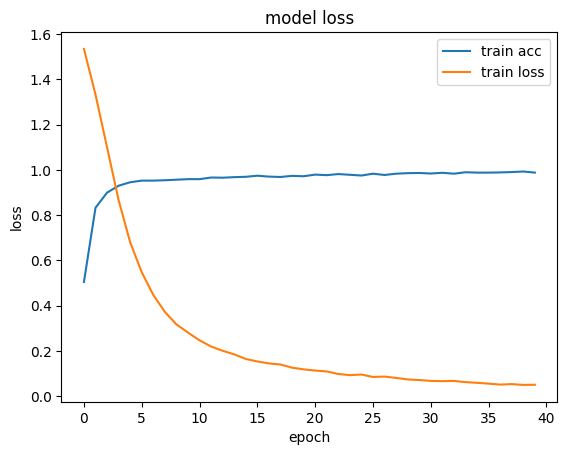

In [138]:
history = model.history
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train acc', 'train loss'], loc='upper right')
plt.show()

In [139]:
# label encoding for validation purposes
le = LabelEncoder().fit(sorted(list(set(df['category'].tolist()))))

11/11 [==============================] - 0s 1ms/step


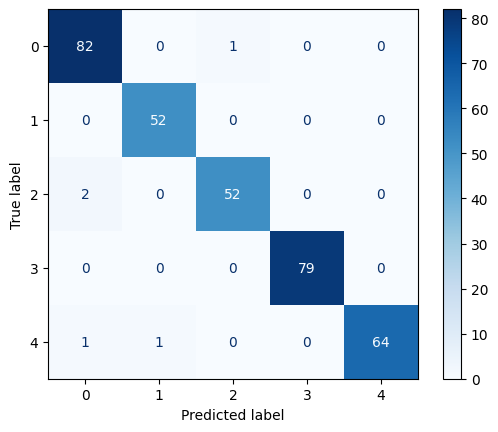

In [140]:
# Confusion Matrix
cm_rm_2 = confusion_matrix(le.transform(lb.inverse_transform(np.array(y_test))),model.predict(x_test).argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rm_2)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [141]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(le.transform(lb.inverse_transform(np.array(y_test))),model.predict(x_test).argmax(axis=1)))

11/11 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.96      0.99      0.98        83
           1       0.98      1.00      0.99        52
           2       0.98      0.96      0.97        54
           3       1.00      1.00      1.00        79
           4       1.00      0.97      0.98        66

    accuracy                           0.99       334
   macro avg       0.99      0.98      0.98       334
weighted avg       0.99      0.99      0.99       334

